# Import Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Data Importing

In [96]:
inventory_df = pd.read_excel('Inventory Dataset.xlsx')
new_inventory_df = pd.read_excel('New Inventory.xlsx')

df_inventory = pd.DataFrame(inventory_df)
df_new_inventory = pd.DataFrame(new_inventory_df)

# # Convert 'Date' and 'Inventory Receive date' to datetime objects
df_inventory['Date'] = pd.to_datetime(df_inventory['Date'])
df_new_inventory['Inventory Receive'] = pd.to_datetime(df_new_inventory['Inventory Receive'])


merged_df = pd.merge(df_inventory, df_new_inventory, how='outer', left_on='Item Number', right_on='Item Number')
merged_df

,Item Number,Date,Inventory,Inventory Receive,Total Item Qty
0,064-01-1347,2023-06-17,3561.0,2023-07-10,2000.0
1,064-01-1347,2023-06-17,3561.0,2023-07-07,1000.0
2,064-01-1347,2023-06-17,3561.0,2023-07-09,3568.0
3,064-01-1347,2023-06-17,3561.0,2023-08-04,1800.0
4,064-01-1361,2023-06-17,4035.0,2023-07-10,2000.0
...,...,...,...,...,...
1224,064-18-4752,NaT,NaN,2023-11-26,12424.0
1225,064-18-3496,NaT,NaN,2023-08-16,20812.0
1226,064-18-3496,NaT,NaN,2023-09-15,9940.0
1227,064-18-4295,NaT,NaN,2023-08-16,14820.0


# Data Preprocessing

In [97]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229 entries, 0 to 1228
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Item Number        1229 non-null   object        
 1   Date               1126 non-null   datetime64[ns]
 2   Inventory          1126 non-null   float64       
 3   Inventory Receive  1039 non-null   datetime64[ns]
 4   Total Item Qty     1039 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 57.6+ KB


In [98]:
merged_df.shape

(1229, 5)

In [99]:
merged_df.isnull().sum()

Item Number            0
Date                 103
Inventory            103
Inventory Receive    190
Total Item Qty       190
dtype: int64

In [100]:
merged_df['Date'].fillna(method='ffill', inplace=True)
merged_df['Inventory Receive'].fillna(method='ffill', inplace=True)
count_inventory = merged_df['Inventory'].count()

merged_df['Inventory'].fillna(count_inventory, inplace=True)
inventory_count = merged_df['Total Item Qty'].count()
merged_df['Total Item Qty'].fillna(inventory_count, inplace=True)
merged_df

,Item Number,Date,Inventory,Inventory Receive,Total Item Qty
0,064-01-1347,2023-06-17,3561.0,2023-07-10,2000.0
1,064-01-1347,2023-06-17,3561.0,2023-07-07,1000.0
2,064-01-1347,2023-06-17,3561.0,2023-07-09,3568.0
3,064-01-1347,2023-06-17,3561.0,2023-08-04,1800.0
4,064-01-1361,2023-06-17,4035.0,2023-07-10,2000.0
...,...,...,...,...,...
1224,064-18-4752,2023-06-17,1126.0,2023-11-26,12424.0
1225,064-18-3496,2023-06-17,1126.0,2023-08-16,20812.0
1226,064-18-3496,2023-06-17,1126.0,2023-09-15,9940.0
1227,064-18-4295,2023-06-17,1126.0,2023-08-16,14820.0


In [101]:
merged_df.isnull().sum()

Item Number          0
Date                 0
Inventory            0
Inventory Receive    0
Total Item Qty       0
dtype: int64

In [102]:
merged_df.describe()

,Inventory,Total Item Qty
count,1229.00000,1229.000000
mean,6840.87144,2184.047193
std,5912.78947,2362.632821
min,1.00000,0.000000
25%,1126.00000,1039.000000
50%,6171.00000,1368.000000
75%,9920.00000,2468.000000
max,27104.00000,23580.000000


In [103]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Feature engineering
merged_df['Day_of_Week'] = merged_df['Date'].dt.dayofweek
merged_df['Month'] = merged_df['Date'].dt.month
# Add more features as needed

# Lagged values
for i in range(1, 4):
    merged_df[f'Inventory_Lag_{i}'] = merged_df['Inventory'].shift(i)

# Rolling statistics
merged_df['Rolling_Mean'] = merged_df['Inventory'].rolling(window=3).mean()

# Create future dates
future_dates = pd.date_range(start='2023-07-01', periods=12, freq='W')

# Create a DataFrame with Inventory values
pivot_df = pd.pivot_table(merged_df, values='Inventory', index='Item Number', columns='Date', aggfunc='sum', fill_value=0)

# Create a DataFrame with future dates and fill with NaN
future_dates_df = pd.DataFrame(index=pivot_df.index, columns=future_dates, data=np.nan)

# Use linear regression to predict future weeks
for item_number in pivot_df.index:
    X = np.array(range(len(pivot_df.columns))).reshape(-1, 1)
    y = pivot_df.loc[item_number].values

    model = LinearRegression()
    model.fit(X, y)

    future_weeks = np.array(range(len(pivot_df.columns), len(pivot_df.columns) + len(future_dates))).reshape(-1, 1)
    predicted_values = model.predict(future_weeks)

    # Fill the corresponding rows in future_dates_df with the predicted values
    future_dates_df.loc[item_number] = predicted_values

# Concatenate the DataFrames
result_df = pd.concat([pivot_df, future_dates_df], axis=1)
result_df


,2023-06-17,2023-07-02,2023-07-09,2023-07-16,2023-07-23,2023-07-30,2023-08-06,2023-08-13,2023-08-20,2023-08-27,2023-09-03,2023-09-10,2023-09-17
Item Number,,,,,,,,,,,,,
064-01-0003,2252,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0
064-01-0005,2252,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0
064-01-0006,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
064-01-0012,2252,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0
064-01-0013,2252,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
064-18-9884,12419,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0,12419.0
064-18-9904,2252,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0,2252.0
064-18-9909,12,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0


# Data Visualization


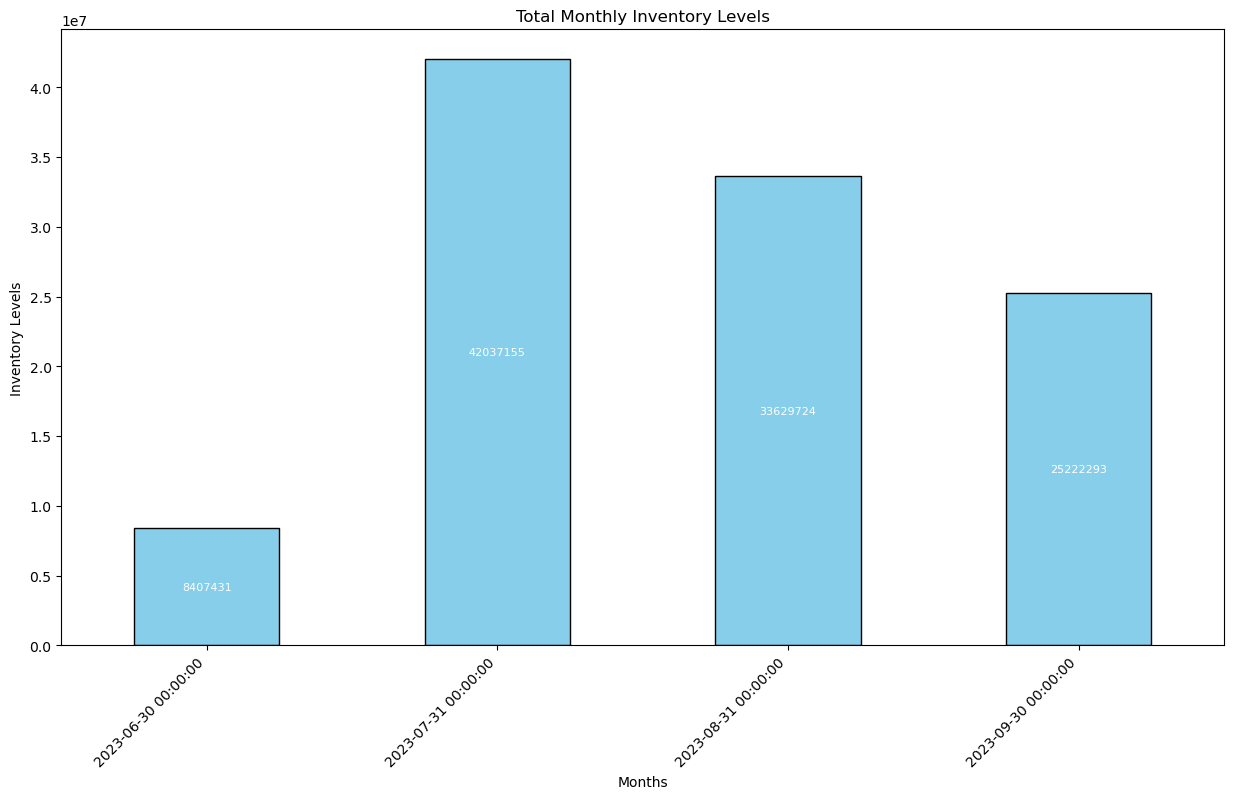

In [92]:
# Resample the DataFrame to get total monthly inventory levels
monthly_inventory = result_df.resample('M', axis=1).sum()

# Create a bar chart for total monthly inventory levels
plt.figure(figsize=(15, 8))
monthly_inventory.sum(axis=0).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Monthly Inventory Levels')
plt.xlabel('Months')
plt.ylabel('Inventory Levels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Annotate the bar chart with actual values
for i, value in enumerate(monthly_inventory.sum(axis=0)):
    plt.text(i, value / 2, f'{value:.0f}', ha='center', va='center', color='white', size=8)

plt.show()